# NSIDC DAAC ICESat-2 Customize and Access Data Tutorial

### This tutorial will walk you though how to access ICESat-2 data at the NASA National Snow and Ice Data Center Distributed Active Archive Center (NSIDC DAAC) using spatial and temporal filters, as well as how to request customization services including subsetting and reformatting using an API. 

## Import packages


In [1]:
import requests, getpass, socket, json, zipfile, io, math, os, shutil, pprint
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth

# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
import fiona
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

## Create a token

### We will generate a token needed in order to access data using your Earthdata Login credentials, and we will apply that token to the following queries. If you do not already have an Earthdata Login account, go to http://urs.earthdata.nasa.gov to register. 

In [3]:
# Earthdata Login credentials

uid = input('Earthdata Login user name: ')
pswd = getpass.getpass('Earthdata Login password: ')
email = input('Email address associated with Earthdata Login account: ')


Earthdata Login user name: Bwallin
Earthdata Login password: ········
Email address associated with Earthdata Login account: bruce.wallin@nsidc.org


In [4]:
# Request token from Common Metadata Repository using Earthdata credentials
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']
print(token)

377A7C3B-27F0-3340-8465-92A2EF9DDE8C


## Select a data set of interest and determine the number and size of granules available within a time range and location.

### Let's begin discovering ICESat-2 data by first inputting the data set of interest and determining the most recent version number. We will also find out how many data granules exist over an area and time of interest. The Common Metadata Repository is queried to explore this information. See https://nsidc.org/data/icesat-2/data-sets for a list of all ICESat-2 data set titles and short names.

In [5]:
# Input data set short name (e.g. ATL06) of interest here.

short_name = input('Input short name, e.g. ATL06, here: ')

Input short name, e.g. ATL06, here: ATL03


In [6]:
# Get json response from CMR collection metadata

params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

The most recent version of  ATL03  is  001


### Now that we have the most recent version of this data set, let's determine the number of granules available over our area and time of interest.

In [9]:
#Input temporal range 

start_date = input('Input start date in yyyy-MM-dd format: ')
start_time = input('Input start time in HH:mm:ss format: ')
end_date = input('Input end date in yyyy-MM-dd format: ')
end_time = input('Input end time in HH:mm:ss format: ')

temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'

Input start date in yyyy-MM-dd format: 2018-11-01
Input start time in HH:mm:ss format: 00:00:00
Input end date in yyyy-MM-dd format: 2018-11-02
Input end time in HH:mm:ss format: 00:00:00


### For our area of interest, let's first choose from the following spatial region selections:
#### 1) Bounding Box 
#### 2) Polygon coordinate pairs 
#### 3) Spatial file input, including Esri Shapefile or KML/KMZ. 
</br>

In [10]:
aoi = str(input('''Enter your selected numbered option (1, 2, or 3)
'''))

Enter your selected numbered option (1, 2, or 3)
3


In [11]:
#prompt for spatial region information depending on input selection

if aoi == '1': 
    #Input bounding box
    LL_lon = input('Input lower left longitude in decimal degrees: ')
    LL_lat = input('Input lower left latitude in decimal degrees: ')
    UR_lon = input('Input upper right longitude in decimal degrees: ')
    UR_lat = input('Input upper right latitude in decimal degrees: ')
    
    bounding_box = LL_lon + ',' + LL_lat + ',' + UR_lon + ',' + UR_lat
    
    #CMR parameters used for granule search
    params = {
    'short_name': short_name,
    'version': latest_version,
    'bounding_box': bounding_box,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1
    }
    
elif aoi == '2':
    print('Polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.')
    polygon = input('''Input polygon coordinates as comma separated values in longitude latitude order, i.e. lon1, lat1, lon2, lat2, lon3, lat3, and so on: 
    ''')
    
    #CMR parameters used for granule search
    params = {
    'short_name': short_name,
    'version': latest_version,
    'polygon': polygon,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1
    }
    
elif aoi == '3':
    kml_filepath = str(os.getcwd()) + '/pine_island_glims/glims_polygons.kml'
    gdf = gpd.read_file(kml_filepath)
    poly = gdf.iloc[0].geometry
    
    #simplify polygon
    poly = poly.simplify(0.05, preserve_topology=False)
    
    #Orient counter-clockwise
    poly = orient(poly, sign=1.0)
    
    #Format dictionary to polygon coordinate pairs for CMR polygon filtering
    polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
    
    #Find bounds of polygon for CMR filtering
    
    #Create shapely polygon object
    #poly = Polygon(tuple(polygon_list))
    #bounds = poly.bounds
    #minx, miny, maxx, maxy
    
    
    #Flatten list, convert to tuple for CMR polygon parameter
    #polygon = sum(polygon_list, [])
    
    #polygon = ','.join(map(str, (sum(polygon_list, [])))) 
    
    #CMR parameters used for granule search
    
    params = {
    'short_name': short_name,
    'version': latest_version,
    'polygon': polygon,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1
    }

### Let's take a look at the KML of Pine Island Glacier from the NSIDC [Global Land Ice Measurements from Space (GLIMS) database](http://www.glims.org/maps/glims). 

#### The Pine Island Glacier outline was downloaded from the following source: http://www.glims.org/maps/download.html?download_type=id&clause=G263560E76894S

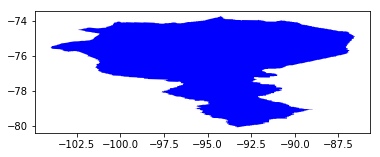

In [13]:
#import geojson python dictionary as Geodataframe
kml_filepath = str(os.getcwd()) + '/pine_island_glims/glims_polygons.kml'
gdf = gpd.read_file(kml_filepath)

#render figure in notebook
%matplotlib inline

polygon_plot = gdf.plot(color='blue')

In [14]:
# Query number of granules (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    params['page_num'] += 1

print('There are', len(granules), 'granules of', short_name, 'version', latest_version, 'over my area and time of interest.')


There are 2 granules of ATL03 version 001 over my area and time of interest.


### We will now query the average size of those granules as well as the total volume. 

In [15]:
granule_sizes = [float(granule['granule_size']) for granule in granules]

print(f'The average size of each granule is {mean(granule_sizes):.2f} MB and the total size of all {len(granules)} granules is {sum(granule_sizes):.2f} MB')


The average size of each granule is 2636.40 MB and the total size of all 2 granules is 5272.80 MB


### Although subsetting, reformatting, or reprojecting can alter the size of the granules, this "native" granule size can still be used to guide us towards the best download method to pursue, which we will come back to later on in this tutorial.

## Select the subsetting and reformatting services enabled for your data set of interest.

### The NSIDC DAAC supports customization services on many of our NASA Earthdata mission collections. Reformatting and subsetting are available on all Level-2 and -3 ICESat-2 data sets. Let's discover the specific service options supported for this data set and select which of these services we want to request. 

### We will start by querying the service capability endpoint and gather service information that we will select in the next step.

In [16]:
# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

#collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]


### We will now select subsetting and reformatting options.

In [17]:
#print service information depending on service availability and select service options
    
if len(subagent) < 1 :
    print('No services exist for', short_name, 'version', latest_version)
    agent = 'NO'
    bbox = ''
    time = ''
    reformat = ''
    projection = ''
    projection_parameters = ''
    coverage = ''
else:
    agent = ''
    subdict = subagent[0]
    #icesat-2 spatial subsetting logic
    if subdict['spatialSubsetting'] == 'true' and subdict['id'] == 'ICESAT2' and aoi == '1':
        print('Subsetting by bounding box, based on the area of interest inputted above, is available.')
        ss = input('Would you like to request this service? (y/n)')
        bounding_shape = ''
        if ss == 'y': 
            bbox = bounding_box
        else: 
            bbox = ''
    #if subdict['spatialSubsetting'] == 'true' and subdict['id'] == 'ICESAT2' and aoi != '2':
    #    print('Subsetting by polygon, based on area of interest inputted above, is available.')
    #    ss = input('Would you like to request this service? (y/n)')
    #    if ss == 'y':
    #        #convert to dictionary for geojson input
    #        ##poly_dict = mapping(cc)
    #    else: 
    #        bounding_shape = ''
    #        bbox = ''
    
    if subdict['spatialSubsetting'] == 'true' and subdict['id'] == 'ICESAT2' and aoi == '3':
        print('Subsetting by polygon, based on the original spatial file inputted above, is available.')
        ss = input('Would you like to request this service? (y/n)')
        bbox = ''
        bounding_shape = ''
        if ss == 'y': upload = 'T'
    if subdict['spatialSubsetting'] == 'true' and subdict['id'] != 'ICESAT2':
        print('Subsetting by bounding box, based on the area of interest inputted above, is available.')
        ss = input('Would you like to request this service? (y/n)')
        if ss == 'y': bbox = bounding_box
        else: bbox = ''
    if subdict['temporalSubsetting'] == 'true':
        print('Subsetting by time, based on the temporal range inputted above, is available.')
        ts = input('Would you like to request this service? (y/n)')
        if ts == 'y': time = temporal 
        else: time = ''
    else: time = ''
    if len(format_vals) > 0 :
        print('These reformatting options are available:', format_vals)
        reformat = input('If you would like to reformat, copy and paste the reformatting option you would like (make sure to omit quotes, e.g. GeoTIFF), otherwise leave blank.')
        # select reprojection options based on reformatting selection
        if reformat in format_proj and len(proj_vals) > 0 : 
            print('These reprojection options are available with your requested format:', proj_vals)
            projection = input('If you would like to reproject, copy and paste the reprojection option you would like (make sure to omit quotes, e.g. GEOGRAPHIC), otherwise leave blank.')
            # Enter required parameters for UTM North and South
            if projection == 'UTM NORTHERN HEMISPHERE' or projection == 'UTM SOUTHERN HEMISPHERE': 
                NZone = input('Please enter a UTM zone (1 to 60 for Northern Hemisphere; -60 to -1 for Southern Hemisphere):')
                projection_parameters = str('NZone:' + NZone)
            else: projection_parameters = ''
        else: 
            print('No reprojection options are supported with your requested format')
            projection = ''
            projection_parameters = ''
    else: 
        reformat = ''
        projection = ''
        projection_parameters = ''


Subsetting by polygon, based on the original spatial file inputted above, is available.
Would you like to request this service? (y/n)y
Subsetting by time, based on the temporal range inputted above, is available.
Would you like to request this service? (y/n)y
These reformatting options are available: ['TABULAR_ASCII', 'NetCDF4-CF', 'NetCDF-3']
If you would like to reformat, copy and paste the reformatting option you would like (make sure to omit quotes, e.g. GeoTIFF), otherwise leave blank.
No reprojection options are supported with your requested format


### Because variable subsetting can include a long list of variables to choose from, we will decide on variable subsetting separately from the service options above.

In [18]:
# Select variable subsetting

if len(variable_vals) > 0:
        v = input('Variable subsetting is available. Would you like to subset a selection of variables? (y/n)')
        if v == 'y':
            print('The', short_name, 'variables to select from include:')
            pprint.pprint(variable_vals)
            coverage = input('If you would like to subset by variable, copy and paste the variables you would like separated by comma. Make sure to omit quotes but include all forward slashes: ')
        else: coverage = ''

#no services selected
if reformat == '' and projection == '' and projection_parameters == '' and coverage == '' and time == '' and bbox == '' and aoi != '3':
    agent = 'NO'
else: agent = ''

Variable subsetting is available. Would you like to subset a selection of variables? (y/n)n


## Request data from the NSIDC data access API.

 _What is an API? API stands for Application Programming Interface. You can think of it as a middle man between an application or end-use (in this case, us) and a data provider (in this case, the Common Metadata Repository and NSIDC). These APIs are essentially structured as a URL with a base plus individual key-value-pairs (KVPs) separated by ‘&’._

### We will now set up our data download request. Recall that we queried the total number and volume of granules prior to applying customization services, so you can use these values to adjust the number of granules per request up to a limit of 100 granules. For now, let's select 10 granules to be processed in each zipped request. 

In [19]:
# Determine how many individual orders we will request based on the number of granules requested

# Set number of granules requested per order, which we will initially set to 10.
page_size = 10
page_num = math.ceil(len(granules)/page_size)

#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

print('There will be', page_num, 'total order(s) processed for our', short_name, 'request.')

There will be 1 total order(s) processed for our ATL03 request.


### Now, let's download the data directly to this notebook directory in a new Outputs folder. The progress of each order will be reported.

In [20]:
#post polygon


In [21]:
#async

request_mode = 'async'
bounding_box = ''
page_val = '1'
agent = 'NO'

request_params = {'short_name': short_name, 'version': latest_version, 'temporal': temporal, 'time': time, 'bounding_box': bounding_box, 'polygon': polygon, 'bbox': bbox, 'bounding_shape': bounding_shape, 'format': reformat, 'projection': projection, 'projection_parameters': projection_parameters, 'Coverage': coverage, 'request_mode': request_mode, 'page_size': page_size, 'page_num': page_val, 'agent': agent, 'token': token, 'email': email, }

# REQUESTID=`grep orderId request.xml | awk -F '<|>' '{print $3}'`

#r = requests.get(base_url, params=request_params)



#s = session.get(capability_url)
#response = session.get(s.url,auth=(uid,pswd))




newsession = requests.session()
news = newsession.get(base_url, params=request_params)
newresponse = session.get(news.url,auth=(uid,pswd))

newroot = ET.fromstring(newresponse.content)



status = [status.attrib for status in newroot.iter('status')]

In [22]:
for child in newroot:
    print(child.tag, child.text)

    
newroot[3][0].text

order 
        
contactInformation 
        
processInfo 
        
requestStatus 
        


'processing'

In [23]:
for requestStatus in newroot.iter('requestStatus'):
    print(requestStatus.attrib)

{}


In [24]:
print(news)
print(newresponse)
print(newresponse.content)
print(newroot)

<Response [201]>
<Response [201]>
b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<eesi:agentResponse xsi:schemaLocation="http://eosdis.nasa.gov/esi/rsp/e https://newsroom.gsfc.nasa.gov/esi/8.1/schemas/ESIAgentResponseExternal.xsd" xmlns="" xmlns:iesi="http://eosdis.nasa.gov/esi/rsp/i" xmlns:ssw="http://newsroom.gsfc.nasa.gov/esi/rsp/ssw" xmlns:eesi="http://eosdis.nasa.gov/esi/rsp/e" xmlns:esi="http://eosdis.nasa.gov/esi/rsp" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n    <order>\n        <orderId>5000000317618</orderId>\n        <Instructions>You may receive an email about your order if you specified an EMAIL address. &lt;br/&gt;&lt;br/&gt;The instructions used to process this order are:  Processing tool=NO. Granule id(s)=SC:ATL03.001:161174427,SC:ATL03.001:161181355. Temporal search start=2018-11-01T00:00:00Z end=2018-11-02T00:00:00Z. Email address=bruce.wallin@nsidc.org.</Instructions>\n    </order>\n    <contactInformation>\n        <contactName>NSIDC User S

In [25]:
subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]
print(subagent)
print(root)

[{'id': 'ICESAT2', 'spatialSubsetting': 'true', 'spatialSubsettingShapefile': 'false', 'temporalSubsetting': 'true', 'type': 'both', 'maxGransSyncRequest': '100', 'maxGransAsyncRequest': '2000'}]
<Element '{http://eosdis.nasa.gov/esi/dataset}DataSets' at 0x7f0f880928b8>


In [26]:
newroot.findall(".")
root.findall("./requestStatus")

[]

In [27]:
type(status)

list

In [28]:
# Create Outputs folder if folder does not already exist, request data service for each page number, and unzip outputs

#set request_mode
request_mode = 'async'

path = str(os.getcwd() + '/Outputs')

if os.path.exists(path):
    for i in range(page_num):
        page_val = i + 1
        request_params = {'short_name': short_name, 'version': latest_version, 'temporal': temporal, 'time': time, 'bounding_box': bounding_box, 'polygon': polygon, 'bbox': bbox, 'bounding_shape': bounding_shape, 'format': reformat, 'projection': projection, 'projection_parameters': projection_parameters, 'Coverage': coverage, 'request_mode': request_mode, 'page_size': page_size, 'page_num': page_val, 'agent': agent, 'token': token, 'email': email, }
        print('Data request', page_val, 'is processing...')
        r = requests.get(base_url, params=request_params)
        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
else:
    path = str(os.getcwd() + '/Outputs')
    os.mkdir(path)
    for i in range(page_num):
        page_val = i + 1
        request_params = {'short_name': short_name, 'version': latest_version, 'temporal': temporal, 'time': time, 'bounding_box': bounding_box, 'polygon': polygon, 'bbox': bbox, 'bounding_shape': bounding_shape, 'format': reformat, 'projection': projection, 'projection_parameters': projection_parameters, 'Coverage': coverage, 'request_mode': request_mode, 'page_size': page_size, 'page_num': page_val, 'agent': agent, 'token': token, 'email': email, }
        print('Data request', page_val, 'is processing...')
        r = requests.get(base_url, params=request_params)
        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')




Data request 1 is processing...


BadZipFile: File is not a zip file

### Finally, we will clean up the Output folder by removing individual order folders:

In [ ]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

### To review, we have explored data availability and volume over a region and time of interest, discovered and selected data customization options, and downloaded data directly to our local machine. You are welcome to request different data sets, areas of interest, and/or customization services by re-running the notebook or starting again at the 'Select a data set of interest' step above. 